In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import time
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from torch.autograd import Variable
from pathlib import Path
from numpy import asarray
from PIL import Image

In [2]:
# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
directoryName = "historgram"
Path(directoryName).mkdir(parents=True, exist_ok=True)

In [4]:
class Generator(nn.Module):
    def __init__(self, npgu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netGLoadDirectory = "HyperparameterData/LSGANadam0.0002l16b"
loadG = Generator(ngpu).to(device)
loadG.load_state_dict(torch.load(netGLoadDirectory+"/netGModel"))

<All keys matched successfully>

In [10]:
#generate fake images
Tensor = torch.cuda.FloatTensor
tempStore = "data/tempstore"
for i in range(120):
    z = Variable(Tensor(np.random.normal(0, 1, (batch_size, 100))))
    #print(z.shape)
    gen_imgs = loadG(z)
    #print(gen_imgs.shape)      
    
    #batch size should be the same as loadG's batch size
    for j in range(batch_size):
        save_image(gen_imgs.data[j], tempStore+"/faketemp"+str(i)+str(j)+".png", nrow=4, padding=0, normalize=True)


In [11]:
#grayscale the 3 channel images for the folder

for filename in os.listdir(netGLoadDirectory+"/fakeImageData"):
    if filename.endswith(".png"): 
        imgfake = Image.open(netGLoadDirectory+"/fakeImageData/"+filename)
        imgfake1c = imgfake.convert('L')  #convert a gray scale
        imgfake1c = imgfake1c.save(netGLoadDirectory+"/fakeImageData/"+filename)

In [14]:
#############################################
#trying it on 256 data 
#############################################
#realfolder ="data/CustomTile/custom"
realfolder ="data/HTile128/HTile128/img_align_HTile"

#fakefolder = "LSGAN2560.0001l2b/testgen"
fakefolder = "data/tempstore"

for filename in os.listdir(fakefolder):
    if filename.endswith(".png"): 
        imgfake = Image.open(fakefolder+"/"+filename)
        imgfake1c = imgfake.convert('L')  #convert a gray scale
        imgfake1c = imgfake1c.save(fakefolder+"/"+filename)

        
Image.MAX_IMAGE_PIXELS = None
heightDistributionreal = [0]*256
heightDistributionfake = [0]*256

#print(heightDistributionreal)
for filename in os.listdir(realfolder):
    if filename.endswith(".jpg"): 
        #print(filename)
        imgreal = Image.open(realfolder+"/"+filename)
        datareal = asarray(imgreal)
        #print(np.max(datareal))
        #print(np.min(datareal))
        heightDistributionreal[np.max(datareal)-np.min(datareal)]+=1
    else:
        continue


#print(heightDistributionreal)
for filename in os.listdir(fakefolder):
    if filename.endswith(".png"): 
        #print(filename)
        imgfake = Image.open(fakefolder+"/"+filename)
        datafake = asarray(imgfake)
        #print(np.max(datareal))
        #print(np.min(datareal))
        heightDistributionfake[np.max(datafake)-np.min(datafake)]+=1
    else:
        continue
        
print(heightDistributionreal)
print(heightDistributionfake)
print("max of height dist:"+str(np.max(heightDistributionreal)))
print("min of height dist:"+str(np.min(heightDistributionreal)))
print("max of height dist:"+str(np.max(heightDistributionfake)))
print("min of height dist:"+str(np.min(heightDistributionfake)))
print(np.sum(heightDistributionreal))
print(np.sum(heightDistributionfake))

#normalize data
#heightNormDistributionreal= np.true_divide(heightDistributionreal, np.sum(heightDistributionreal))


[0, 0, 0, 0, 0, 0, 3, 2, 5, 15, 35, 54, 134, 274, 411, 426, 387, 351, 319, 309, 306, 270, 240, 261, 238, 223, 210, 194, 190, 178, 208, 152, 187, 168, 129, 164, 170, 165, 166, 158, 155, 145, 125, 128, 98, 109, 118, 119, 127, 116, 126, 109, 114, 106, 119, 117, 98, 90, 92, 93, 83, 106, 118, 82, 91, 71, 87, 76, 72, 75, 73, 70, 56, 59, 68, 55, 43, 61, 43, 51, 57, 47, 46, 56, 35, 51, 40, 32, 41, 46, 29, 31, 24, 27, 32, 27, 26, 28, 31, 21, 25, 28, 34, 20, 14, 23, 14, 13, 22, 16, 19, 24, 15, 21, 12, 11, 11, 16, 16, 12, 15, 14, 10, 15, 16, 18, 11, 15, 14, 13, 5, 11, 9, 6, 5, 12, 10, 12, 7, 9, 13, 8, 10, 5, 13, 10, 6, 10, 7, 9, 7, 6, 4, 7, 4, 8, 6, 8, 5, 6, 5, 5, 6, 4, 2, 3, 5, 9, 4, 5, 2, 4, 2, 4, 5, 6, 4, 2, 5, 5, 1, 2, 2, 1, 2, 4, 2, 3, 3, 2, 0, 2, 6, 3, 2, 3, 3, 3, 3, 1, 2, 1, 3, 1, 2, 4, 3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 0, 3, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

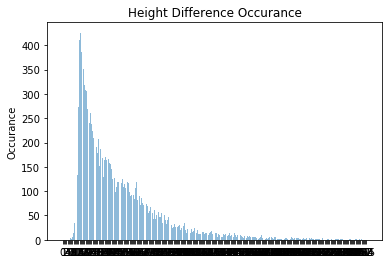

In [15]:
objects = tuple(range(0,256))
#print(objects)
#print(type(objects))
y_pos = np.arange(len(objects))
performance = heightDistributionreal

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Occurance')
plt.title('Height Difference Occurance')

plt.show()

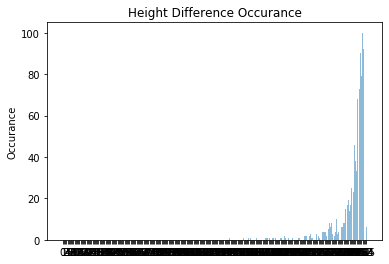

In [16]:
objects = tuple(range(0,256))
#print(objects)
#print(type(objects))
y_pos = np.arange(len(objects))
performance = heightDistributionfake

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Occurance')
plt.title('Height Difference Occurance')

plt.show()